## Generic AI

In [1]:
from graphviz import Source

# 1) Your DOT definition
dot_source = """

digraph ML_Schematic {
  rankdir=LR;
  node [fontname="Arial"];

  input   [shape=circle,   label="Input"];
  model    [shape=box3d,   label=<<B>MODEL</B> { Parameter 1 | Parameter 2 | ... | Parameter 1000}>, style=filled, fillcolor="#AED6F1"];
  output   [shape=circle,   label="AI\nOutput"];

  input -> model;
  model  -> output;
}
"""

# 2) Create a Source object
src = Source(dot_source)

# 3) Render to PNG
#    This will create 'ML_Schematic.png' in your cwd
src.render(filename='ML_Schematic', format='png', cleanup=True)

print("Generated ML_Schematic.png")

Generated ML_Schematic.png


In [2]:
from graphviz import Source

# 1) Your DOT definition
dot_source = """digraph ML_Schematic {
  rankdir=TB;
  node [fontname="Arial"];

  // Top row
  { rank=same; input; model; output; }

  // Bottom row (in left-to-right order: update under model, then target under output)
  { rank=same; update; target; }
  { rank = max; target}

  // Nodes
  input   [shape=circle, label="Training\nData X"];
  model   [shape=box3d,
           label=<<B>MODEL</B> { Parameter 1 | Parameter 2 | … | Parameter 1000 }>,
           style=filled, fillcolor="#AED6F1"];
  output  [shape=circle, label="AI\nOutput"];
  update  [shape=box,    label="Update\nParameters", style=dashed];
  target  [shape=circle, label="Training\nData Y"];
  error   [shape=diamond,label="Loss\n(Target−Output)", style=filled, fillcolor="#FAD7A0"];


  // Invisible edges to lock columns
  update  -> model  [style=invis];
  // output -> target  [style=invis];
  // target -> output [style=invis];

  // Real data flow
  input  -> model -> output;
  output -> error;
  target -> error;
  error  -> update -> model;
}
"""

# 2) Create a Source object
src = Source(dot_source)

# 3) Render to PNG
#    This will create 'ML_Schematic.png' in your cwd
src.render(filename='ML_Training_Schematic', format='png', cleanup=True)

print("Generated ML_Training_Schematic.png")

Generated ML_Training_Schematic.png


**I should discuss the specific Loss function used in the previous class and point out the two parameters in our previous model**

## Perceptron Version One

<img alt="Natural and artificial neurons" width="500" caption="Natural and artificial neurons" src="lesson_images/chapter7_neuron.png" id="neuron"/>

Inspired by real neurones - multiple incoming signals arrive at different dendrites, with different sensitivity (**weight**). If they add together in the right combination, the neurone fires.

Let's build a simple neural net - the Rosenblatt perceptron - to read handwritten numbers. It will have 10 neurones, one for each number from 0...9 that we want to detect. The right neurone should turn on for the right number. 

Our Perceptron will "see" images of numbers (from the MNIST public training set) which are 28x28 = 784 pixels. So each neurone will have 784 dendrites - one for each pixel in the image - and each dendrite will have its own sensitivity to each pixel, called the **weight**. 

Each neurone will also have a total sensitivity which decides how easily it is turned on by the pixels. This is called the **bias** (which has more than one meaning in AI - ask me about it!).

In total our Perceptron model will have 784x10 = 7840 **weights** and 1x10 = 10 **biases**. So it has 7850 total parameters it must learn.

Today we will only make our perceptron learn how to recognise two numbers - 3 and 7 - using two neurones. This means our model only needs 784x2 = 1568 weights and 1x2 = 2 biases for a total of 1570 parameters. This will be approximately 5 times faster to train than learning all 10 numbers.

In [3]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [4]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [5]:
path = untar_data(URLs.MNIST_SAMPLE) # Download the MNIST training images

In [6]:
path

Path('/home/harvey/.fastai/data/mnist_sample')

In [ ]:
# Path.BASE_PATH = path # DON'T DO THIS BECAUSE IT WILL MESS UP MY NOTEBOOK

<Axes: >

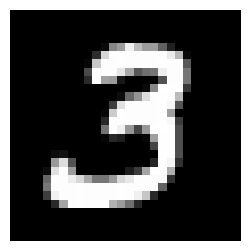

In [7]:
example_image_path = (path/'train'/'3').ls()[0]
example_image = PILImage.create(example_image_path)
example_image.show(figsize=(3,3))

In [8]:
# DO NOT CHANGE THIS CODE
# This code opens up all of our images and puts them into two big lists
# We use a library called 'torch' becuase it does it in a way that allows
# ..the computer to make very fast calculations

stacked_sevens = torch.stack([tensor(Image.open(o)) for o in (path/'train'/'7').ls()]).float()/255 # Brightness is between 0 and 255 but we want it between 0 and 1
stacked_threes = torch.stack([tensor(Image.open(o)) for o in (path/'train'/'3').ls()]).float()/255 # Brightness is between 0 and 255 but we want it between 0 and 1

stacked_sevens.shape, stacked_threes.shape
# Our lists have around 6000 images, each of which is 28x28 pixels

(torch.Size([6265, 28, 28]), torch.Size([6131, 28, 28]))

In [9]:
# DO NOT CHANGE THIS CODE
# Here we combine our two lists into one big list
# We also take each 28x28 square image and turn it into a long list of 784 pixels

train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_x.shape

# Our list shape is approximately (12000, 784) - 12000 lots of lists of 784 pixels

torch.Size([12396, 784])

In [10]:
# DO NOT CHANGE THIS CODE
# Here we create the training output - our model should output [1,0] when it sees a 3 and [0,1] when it sees a 7
# ..this corresponds to the three-neurone turning on for a 3 and the seven-neurone turning on for a 7
# ..in our training data, we will use [0.9, 0.1] for a 3 and [0.1, 0.9] for a 7 because it is difficult to get the model to output exactly 0 or 1

train_y = tensor([[1.0,0.0]]*len(stacked_threes) + [[0.0, 1.0]]*len(stacked_sevens))
train_y.shape

train_y[8000]
# our list shape is approximately (12000, 2) - 12000 lots of lists of 2 numbers

tensor([0., 1.])

In [ ]:
dset = list(zip(train_x, train_y)) # This creates a total dataset ready to train our model

In [ ]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [11]:
class OneLayerPerceptron():

    def __init__(self, std=1.0):
        self.weights = (torch.randn(28*28, 2)*std).requires_grad_() # This 
        self.biases = (torch.randn(2)*std).requires_grad_() # This is the bias for the neurone

    def predict(self, x):
        # return F.softmax(((x @ self.weights) + self.biases).sigmoid(), dim=1)
        return F.softmax((x @ self.weights) + self.biases, dim=1) # This is the output of our model 


    def loss(self, input, training_output):
        return F.mse_loss(self.predict(input), training_output)
    
    def train_one_step(self, input_batch, training_output_batch):

        x = input_batch
        y = training_output_batch

        loss = self.loss(x, y)
        loss.backward() # This calculates the gradients for our weights and biases
        with torch.no_grad(): # This means we are not calculating gradients for the next step
            self.weights -= self.weights.grad * 0.01 # This is the learning rate
            self.biases -= self.biases.grad * 0.01
        self.weights.grad.zero_()
        self.biases.grad.zero_()
        return loss.item()
    
    def get_batch(self, input, training_output, batch_size=64):
        idxs = torch.randint(0, len(input), (batch_size,))
        # print(f"Batch indices: {idxs}")  # Debugging line to check indices
        return input[idxs], training_output[idxs]
    
    def train(self, input, training_data, cycles, batch_size=64):
        for i in range(cycles):
            input_batch, training_output_batch = self.get_batch(input, training_data, batch_size)
            loss = self.train_one_step(input_batch, training_output_batch)
            correct_percentage = (self.predict(input_batch).argmax(dim=1) == training_output_batch.argmax(dim=1)).float().mean().item()
            if i % 20 == 0:
                print(f"Cycle {i}, Loss: {loss:.4f}, Accuracy: {correct_percentage:.2%}")

In [58]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

In [62]:
binary_cross_entropy(tensor([[0.3, 0.8]]), tensor([[0.1, 0.9]]))

tensor(1.0127)

In [18]:
model = OneLayerPerceptron() # Create a model with 784 inputs and 2 outputs (for the two neurones)

In [14]:
test_image = Image.open(example_image_path)
test_image_tensor = tensor(test_image).view(-1, 28*28).float()/255
test_image

In [234]:
model.predict(test_image_tensor)


tensor([[2.7027e-06, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)

In [19]:
input_batch, training_output_batch = model.get_batch(train_x, train_y, 64)
model.train_one_step(input_batch, training_output_batch)
model.predict(test_image_tensor)

model.train(train_x, train_y, 10000, batch_size=256)
model.predict(test_image_tensor)

Cycle 0, Loss: 0.4709, Accuracy: 51.56%
Cycle 20, Loss: 0.4690, Accuracy: 51.17%
Cycle 40, Loss: 0.4299, Accuracy: 54.69%
Cycle 60, Loss: 0.4636, Accuracy: 51.17%
Cycle 80, Loss: 0.3670, Accuracy: 61.72%
Cycle 100, Loss: 0.4664, Accuracy: 50.78%
Cycle 120, Loss: 0.4290, Accuracy: 55.47%
Cycle 140, Loss: 0.4047, Accuracy: 58.20%
Cycle 160, Loss: 0.4036, Accuracy: 57.42%
Cycle 180, Loss: 0.4117, Accuracy: 57.42%
Cycle 200, Loss: 0.4641, Accuracy: 51.95%
Cycle 220, Loss: 0.4581, Accuracy: 51.17%
Cycle 240, Loss: 0.4382, Accuracy: 53.52%
Cycle 260, Loss: 0.3928, Accuracy: 58.59%
Cycle 280, Loss: 0.4091, Accuracy: 56.25%
Cycle 300, Loss: 0.3956, Accuracy: 58.20%
Cycle 320, Loss: 0.4215, Accuracy: 55.47%
Cycle 340, Loss: 0.3659, Accuracy: 60.16%
Cycle 360, Loss: 0.4391, Accuracy: 53.12%
Cycle 380, Loss: 0.4056, Accuracy: 56.25%
Cycle 400, Loss: 0.3902, Accuracy: 58.98%
Cycle 420, Loss: 0.4222, Accuracy: 54.30%
Cycle 440, Loss: 0.3739, Accuracy: 60.55%
Cycle 460, Loss: 0.3438, Accuracy: 62.89

tensor([[1.0000e+00, 1.1996e-13]], grad_fn=<SoftmaxBackward0>)

In [17]:
model.train(train_x, train_y, cycles=100000, batch_size=256)

Cycle 0, Loss: 0.3494, Accuracy: 62.89%
Cycle 20, Loss: 0.3617, Accuracy: 60.55%
Cycle 40, Loss: 0.3345, Accuracy: 64.06%
Cycle 60, Loss: 0.3437, Accuracy: 61.33%
Cycle 80, Loss: 0.3083, Accuracy: 64.84%
Cycle 100, Loss: 0.3276, Accuracy: 64.06%
Cycle 120, Loss: 0.2981, Accuracy: 66.02%
Cycle 140, Loss: 0.2852, Accuracy: 66.80%
Cycle 160, Loss: 0.3668, Accuracy: 59.38%
Cycle 180, Loss: 0.3194, Accuracy: 65.23%
Cycle 200, Loss: 0.3994, Accuracy: 53.52%
Cycle 220, Loss: 0.3206, Accuracy: 64.06%
Cycle 240, Loss: 0.2846, Accuracy: 66.02%
Cycle 260, Loss: 0.3087, Accuracy: 66.02%
Cycle 280, Loss: 0.2657, Accuracy: 70.31%
Cycle 300, Loss: 0.3331, Accuracy: 62.11%
Cycle 320, Loss: 0.2698, Accuracy: 68.36%
Cycle 340, Loss: 0.2726, Accuracy: 69.14%
Cycle 360, Loss: 0.3155, Accuracy: 64.45%
Cycle 380, Loss: 0.2625, Accuracy: 71.09%
Cycle 400, Loss: 0.2979, Accuracy: 66.80%
Cycle 420, Loss: 0.3014, Accuracy: 67.19%
Cycle 440, Loss: 0.2647, Accuracy: 69.14%
Cycle 460, Loss: 0.2430, Accuracy: 72.27

KeyboardInterrupt: 

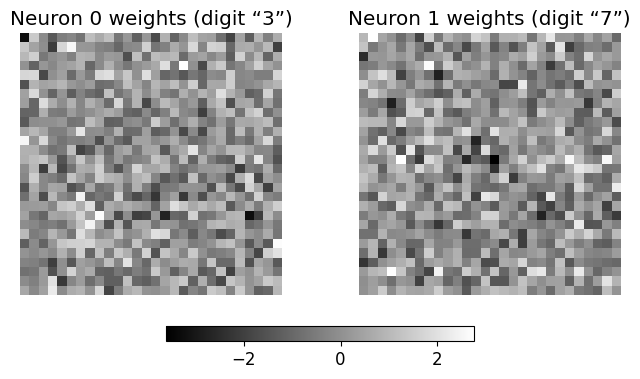

In [242]:
import matplotlib.pyplot as plt
import numpy as np

# 1) Grab the learned weights (shape [784,2])
W = model.weights.detach().numpy()
B = model.biases.detach().numpy()

# 2) Turn each neuron’s weight‐vector into a 28×28 image
weight_imgs = [W[:,i].reshape(28,28) for i in range(W.shape[1])]
titles = ['Neuron 0 weights (digit “3”)', 'Neuron 1 weights (digit “7”)']

# 3) Plot side by side with a diverging colormap
fig, axs = plt.subplots(1, 2, figsize=(8,4))
for ax, img, title in zip(axs, weight_imgs, titles):
    im = ax.imshow(img, cmap='grey', vmin=W.min(), vmax=W.max())
    ax.set_title(title)
    ax.axis('off')

# 4) Shared colorbar
fig.colorbar(im, ax=axs, orientation='horizontal', fraction=0.05, pad=0.1)
plt.show()

In [244]:
F.softmax(((test_image_tensor @ W) + B), dim=1)


/tmp/ipykernel_4526/3756385829.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  F.softmax(((test_image_tensor @ W) + B), dim=1)


tensor([[1.0000e+00, 3.3183e-22]])

In [246]:
test_image_tensor @ W + B

/tmp/ipykernel_4526/3343409432.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_image_tensor @ W + B


tensor([[ 25.0981, -24.3593]])

In [258]:
test_image_tensor[0].T @ W[:,1]  # This will show the first row of the test image tensor, which is a flattened version of the image

/tmp/ipykernel_4526/403436398.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_image_tensor[0].T @ W[:,1]  # This will show the first row of the test image tensor, which is a flattened version of the image


tensor(-25.7817)

In [256]:
W[5*28:5*28+28, 0]  # This will show the weights for the first neurone (for digit "3") for the first row of the test image tensor

array([-1.5564365 ,  0.8931831 ,  0.45839277,  0.5825313 ,  0.9216635 ,  0.19199225, -0.05641396,  0.28253803, -0.87030935, -0.7613165 , -0.2131075 ,  1.164775  ,  0.49199268, -0.28703997,
        0.9313618 ,  0.48143506,  1.1191024 ,  0.06295864,  1.5088984 , -1.0445366 ,  0.5882071 ,  0.57194173,  1.5031605 , -0.2832421 , -0.17981906,  0.09706424,  0.60298395,  0.92422   ],
      dtype=float32)

In [253]:
test_image_tensor.shape

torch.Size([1, 784])

/tmp/ipykernel_4526/3576976545.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,1,1])


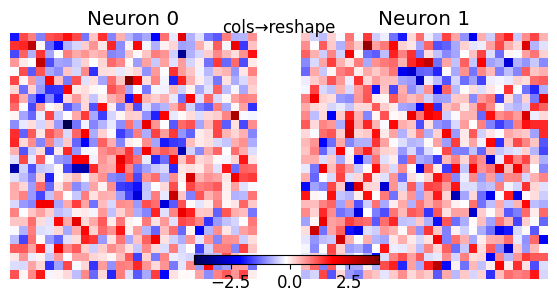

In [229]:
import matplotlib.pyplot as plt
import numpy as np

# Pull out your weights tensor and move to CPU/NumPy
W = model.weights.detach().cpu().numpy()  # shape is either (784,2) or (2,784)

# Build two sets of candidate images:
# 1) assuming neurons are columns in W (shape [784,2])
# 2) assuming neurons are rows in W (shape [2,784])
candidates = []
if W.shape == (784, 2):
    # Option A: each column is length-784
    imgsA = [W[:,i].reshape(28,28) for i in range(2)]
    candidates.append(('cols→reshape', imgsA))
if W.shape == (2, 784):
    # Option B: each row is length-784
    imgsB = [W[i,:].reshape(28,28) for i in range(2)]
    candidates.append(('rows→reshape', imgsB))

# If neither matched, try transposing
if not candidates:
    Wt = W.T
    if Wt.shape == (784,2):
        imgsT = [Wt[:,i].reshape(28,28) for i in range(2)]
        candidates.append(('transpose→cols→reshape', imgsT))

# Plot all candidates
fig, axes = plt.subplots(len(candidates), 2, figsize=(6, 3*len(candidates)))
if len(candidates)==1: axes = axes[None,:]  # unify indexing
for row, (label, imgs) in enumerate(candidates):
    fig.text(0.5, 1 - (row*0.5 + 0.1), label, ha='center', va='center', fontsize=12)
    for col, img in enumerate(imgs):
        ax = axes[row, col]
        im = ax.imshow(img, cmap='seismic', vmin=W.min(), vmax=W.max())
        ax.set_title(f'Neuron {col}')
        ax.axis('off')

fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', fraction=0.04, pad=0.02)
plt.tight_layout(rect=[0,0,1,1])
plt.show()


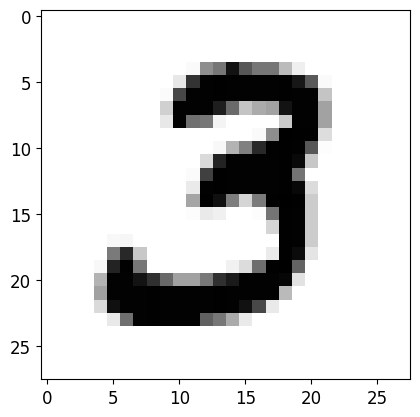

In [214]:
test_imgs = test_image_tensor.reshape(28,28)
plt.imshow(test_imgs, cmap='Greys')


In [110]:
model.predict(test_image_tensor)

tensor([[0.7308, 0.2692]], grad_fn=<SoftmaxBackward0>)

In [43]:
tensor(Image.open(example_image_path)).shape

torch.Size([28, 28])

In [ ]:
model.predict(tensor(example_image).view(1, -1)) # This will give us the output of our model for the example image

In [35]:
model.weights.shape, model.biases.shape

(torch.Size([784, 2]), torch.Size([2]))

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def load_and_preprocess_np(image_path, crop_box=None):
    """
    Load an image, optionally crop, resize to 28×28 grayscale,
    normalize to [0,1], flatten to (784,), and display the image.
    """
    # Load and optional crop
    img = Image.open(image_path)
    if crop_box:
        img = img.crop(crop_box)
    # Grayscale & resize
    img = img.convert('L').resize((28,28), resample=Image.LANCZOS)
    # Normalize to [0,1]
    arr = np.array(img, dtype=np.float32) / 255.0  # shape (28,28)
    arr = 1.0 - arr  # Invert the image (white becomes black and vice versa)
    # Display the processed image
    plt.figure(figsize=(3,3))
    plt.imshow(arr, cmap='gray', vmin=0, vmax=1)
    plt.title('Preprocessed 28×28 Image')
    plt.axis('off')
    plt.show()
    # Flatten to (784,)
    flat = arr.ravel()
    return flat

# Example usage:



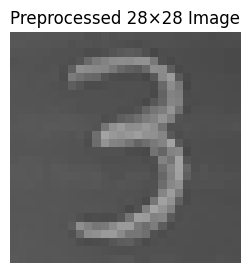

Flat vector shape: (784,)
Value range: 0.2745098 0.6431372


In [2]:
flat_vector = load_and_preprocess_np('lesson_images/phone_crop.jpg')
print("Flat vector shape:", flat_vector.shape)   # (784,)
print("Value range:", flat_vector.min(), flat_vector.max())  # values in [0.0, 1.0]

In [273]:
model.predict(tensor(flat_vector).reshape(1, -1))  # Reshape to (1, 784) for prediction

tensor([[1.0000e+00, 4.5261e-08]], grad_fn=<SoftmaxBackward0>)

## Neural Nets and Deep Learning

## Convolutions

<img src="lesson_images/chapter9_conv_basic.png" id="basic_conv" caption="Applying a kernel to one location" alt="Applying a kernel to one location" width="700">

In [14]:
import numpy as np
import matplotlib.pyplot as plt

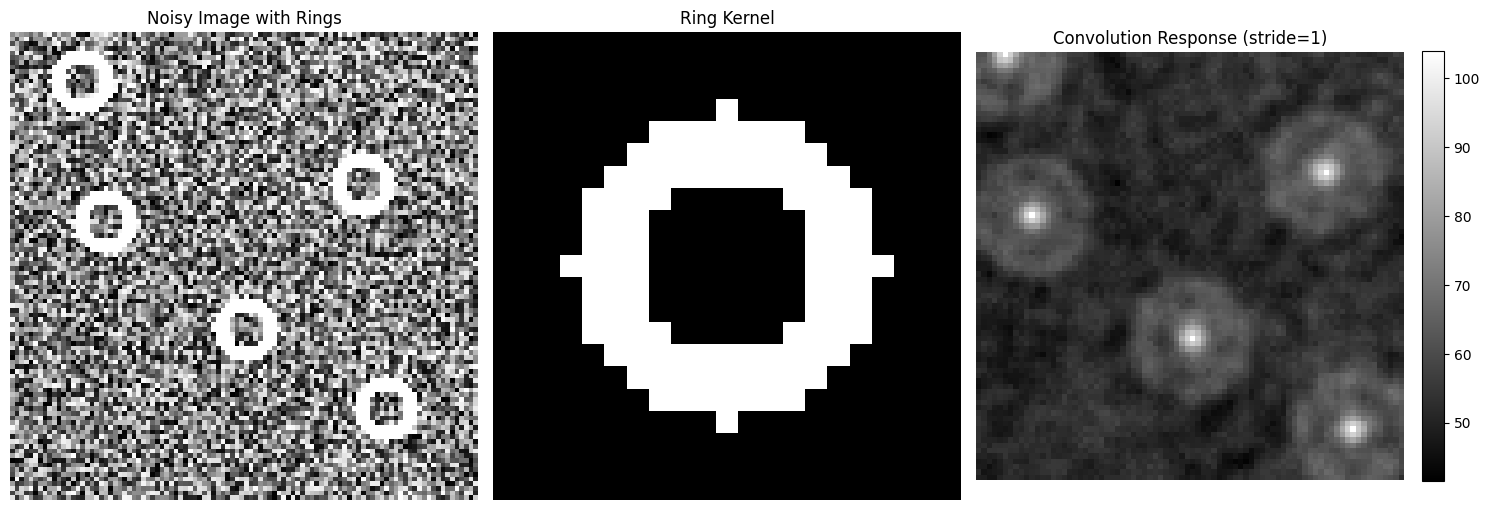

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Create a noisy image with a thicker circular ring
size = 100
np.random.seed(0)
img = np.random.rand(size, size)  # random noise background
yy, xx = np.mgrid[:size, :size]

centres = [(10, 15), (32, 75), (40, 20), (63, 50), (80, 80)]
r_outer, r_inner = 7, 4  # thicker ring radii


for center in centres:
    yy_center, xx_center = center
    distance_sq = (xx - xx_center)**2 + (yy - yy_center)**2
    ring_mask = (distance_sq <= r_outer**2) & (distance_sq >= r_inner**2)
    img[ring_mask] = 1.0  # bright thicker ring


# 2) Create a matching thicker ring kernel
k_size = 21
yyk, xxk = np.mgrid[:k_size, :k_size]
k_center = k_size // 2
# Scale radii proportional to image/kern ratio
scale = 1
k_outer = int(r_outer * scale)
k_inner = int(r_inner * scale)
kernel_mask = ((xxk - k_center)**2 + (yyk - k_center)**2 <= k_outer**2) & \
              ((xxk - k_center)**2 + (yyk - k_center)**2 >= k_inner**2)
kernel = kernel_mask.astype(float)

# 3) Define stride-1 convolution
def conv2d(image, kernel):
    ih, iw = image.shape
    kh, kw = kernel.shape
    oh, ow = ih - kh + 1, iw - kw + 1
    out = np.zeros((oh, ow))
    for i in range(oh):
        for j in range(ow):
            out[i, j] = np.sum(image[i:i+kh, j:j+kw] * kernel)
    return out

# 4) Compute the convolution response
response = conv2d(img, kernel)

# 5) Plot results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Noisy image with thick ring
axes[0].imshow(img, cmap='gray')
axes[0].set_title('Noisy Image with Rings')
axes[0].axis('off')

# Thicker ring kernel
axes[1].imshow(kernel, cmap='gray')
axes[1].set_title('Ring Kernel')
axes[1].axis('off')

# Convolution response heatmap
# im = axes[2].imshow(response, cmap='hot', interpolation='nearest')
im = axes[2].imshow(response, cmap='grey', interpolation='nearest')

axes[2].set_title('Convolution Response (stride=1)')
axes[2].axis('off')

# Colorbar
fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


"In 2013 a PhD student, Matt Zeiler, and his supervisor, Rob Fergus, published the paper ["Visualizing and Understanding Convolutional Networks"](https://arxiv.org/pdf/1311.2901.pdf), which showed how to visualize the neural network weights learned in each layer of a model. They carefully analyzed the model that won the 2012 ImageNet competition, and used this analysis to greatly improve the model, such that they were able to go on to win the 2013 competition! <<img_layer1>> is the picture that they published of the first layer's weights."

<img src="lesson_images/layer1.png" alt="Activations of the first layer of a CNN" width="300" caption="Activations of the first layer of a CNN (courtesy of Matthew D. Zeiler and Rob Fergus)" id="img_layer1">


<img src="lesson_images/layer2.png" alt="Activations of the second layer of a CNN" width="800" caption="Activations of the second layer of a CNN (courtesy of Matthew D. Zeiler and Rob Fergus)" id="img_layer2">

<img src="lesson_images/chapter2_layer3.PNG" alt="Activations of the third layer of a CNN" width="800" caption="Activations of the third layer of a CNN (courtesy of Matthew D. Zeiler and Rob Fergus)" id="img_layer3">

<img src="lesson_images/chapter2_layer4and5.PNG" alt="Activations of layers 4 and 5 of a CNN" width="800" caption="Activations of layers 4 and 5 of a CNN (courtesy of Matthew D. Zeiler and Rob Fergus)" id="img_layer4">

### 14_resnet.ipynb - **LOSS SMOOTHING!!!**

**NOTA BENE:** Perhaps relevant to sampling CF thoughts re a Ricii-flow/normalising flow like method

"Now we're making good progress!

The authors of the ResNet paper went on to win the 2015 ImageNet challenge. At the time, this was by far the most important annual event in computer vision. We have already seen another ImageNet winner: the 2013 winners, Zeiler and Fergus. It is interesting to note that in both cases the starting points for the breakthroughs were experimental observations: observations about what layers actually learn, in the case of Zeiler and Fergus, and observations about which kinds of networks can be trained, in the case of the ResNet authors. This ability to design and analyze thoughtful experiments, or even just to see an unexpected result, say "Hmmm, that's interesting," and then, most importantly, set about figuring out what on earth is going on, with great tenacity, is at the heart of many scientific discoveries. Deep learning is not like pure mathematics. It is a heavily experimental field, so it's important to be a strong practitioner, not just a theoretician.

Since the ResNet was introduced, it's been widely studied and applied to many domains. One of the most interesting papers, published in 2018, is Hao Li et al.'s ["Visualizing the Loss Landscape of Neural Nets"](https://arxiv.org/abs/1712.09913). It shows that using skip connections helps smooth the loss function, which makes training easier as it avoids falling into a very sharp area. <<resnet_surface>> shows a stunning picture from the paper, illustrating the difference between the bumpy terrain that SGD has to navigate to optimize a regular CNN (left) versus the smooth surface of a ResNet (right)."

<img alt="Impact of ResNet on loss landscape" width="600" caption="Impact of ResNet on loss landscape (courtesy of Hao Li et al.)" id="resnet_surface" src="lesson_images/att_00044.png">